# Предсказание оценок вин

Данный датасет попал ко мне волей случая с одного популярного маркетплейса вин. Данные - две таблицы, содержащие следующую информацию:

 - id пользователей, информация об их аккаунтах (кол-во оценок, подписчиков, подписок, лайков), id вина, немножко информации о нём, оценка, поставленная данным пользователем данному вину и др.
 - непосредественно характеристики, взятые из базы вин: опять же id, производитель страна производства, средний рейтинг, информация о производителе, вкусовые и химические характеристики (% алкоголя, сладость) и др.

Хотим проанализировать данные и научиться предсказывать рейтинги вин с использованием методов коллаборативной фильтрации, обработки текстовых признаков и машинного обучения. Сразу хочется отметить, что несмотря на типовое сведение такой задачи к задаче классификации как к предсказанию, какую точно оценку из ограниченного числа возможных поставит пользователь, данная задача формулируется как задача регрессии. Это сделано из желания получить больше информации из ошибок предсказаний нормализованного рейтинга - количественную меру отклонения от истинных оценок, а не долю верных предсказаний. Кроме того, хоть выставляемые рейтинги и дискретны, ошибки выставления 4.0 или 1.5 вместо 4.5 не равнозначны. Отметим, что в задаче регрессии предполагается равномерная плотность пространства признаков (т.е. разница между оценками 3 и 4 равна разнице между 1 и 2), поэтому в дальнейшем будет иметь смысл нормализация таргета.

В рамках такой постановки будем оценивать качество моделей с помощью RMSE и MAE как на более легко интерпретируемые. На графиках сравнения моделей предпочту выводить именно МАЕ, так как эта оценка прямо говорит нам среднюю величину отклонения.



In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import model_selection as ms
from sklearn import metrics
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, FunctionTransformer, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import xgboost as xgb

from surprise import SVD, Reader, Dataset, SVDpp
from surprise.model_selection import GridSearchCV
from surprise import NormalPredictor, BaselineOnly
from surprise.model_selection import cross_validate

from collections import OrderedDict

Загрузим обе таблицы и посмотрим на результаты описательноого анализа.

In [2]:
reviews = pd.read_csv('reviews.csv')
reviews.describe()

,rating,review_comments,review_likes,user_follower_count,user_following_count,user_id,user_rating_count,user_reviews_count,wine_id,wine_labels_count,wine_ratings_average,wine_ratings_count,wine_reviews_count
count,99087.000000,99087.000000,99087.000000,99087.000000,99087.000000,9.908700e+04,99087.00000,99087.000000,99087.000000,99087.000000,99087.000000,99087.000000,99087.000000
mean,3.821480,2.978665,19.398004,1409.410397,457.899139,7.306021e+06,929.37676,831.081464,10580.605528,8436.998627,3.773564,3016.010677,485.890177
std,0.603595,8.955136,40.147512,4298.706241,2741.966749,7.025727e+06,1205.52568,1147.839191,7066.033073,15954.793938,0.379097,6157.951815,849.444186
min,1.000000,0.000000,0.000000,0.000000,0.000000,9.700000e+01,0.00000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000
25%,3.500000,0.000000,0.000000,7.000000,7.000000,1.941739e+06,157.00000,122.000000,4407.000000,418.000000,3.500000,197.000000,37.000000
50%,4.000000,0.000000,2.000000,75.000000,50.000000,4.773092e+06,490.00000,394.000000,8817.000000,2087.000000,3.800000,857.000000,155.000000
75%,4.000000,1.000000,20.000000,608.000000,227.000000,1.037788e+07,1228.00000,1077.500000,15967.000000,8460.000000,4.000000,3194.000000,543.000000
max,5.000000,403.000000,732.000000,63603.000000,209850.000000,3.060972e+07,11953.00000,11870.000000,27374.000000,107031.000000,5.000000,74687.000000,5893.000000


In [3]:
wines = pd.read_csv('wines.csv')
wines.describe()

,alcohol,country_regions_count,country_users_count,country_wineries_count,country_wines_count,rank,region_id,sweetness_id,type_id,wine_id,wine_labels_count,wine_ratings_average,wine_ratings_count,wine_vintages_count,winery_id,winery_labels_count,winery_ratings_average,winery_ratings_count,winery_vintages_count
count,15179.000000,15179.000000,1.517900e+04,15179.000000,15179.00000,0.0,15179.000000,640.000000,15179.000000,15179.000000,15179.000000,15179.000000,15179.000000,15179.000000,15179.000000,1.517900e+04,15179.000000,15179.000000,15179.000000
mean,9.127182,405.525199,3.410878e+06,24436.713617,177488.28770,NaN,791.762369,5.178125,1.824297,12135.792015,4131.941498,3.453844,765.491205,19.847091,13793.612952,1.102531e+05,3.680980,19182.229857,62.514131
std,6.487692,356.943871,2.609798e+06,17400.268082,109953.91636,NaN,876.530764,0.684839,2.131907,7069.437460,15842.723877,1.057943,2761.674079,14.780259,40097.048743,2.303390e+05,0.622204,37518.257677,201.957474
min,0.000000,-1.000000,-1.000000e+00,-1.000000,-1.00000,NaN,-1.000000,2.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000
25%,0.000000,119.000000,8.095880e+05,10774.000000,76229.00000,NaN,201.000000,5.000000,1.000000,6059.500000,33.000000,3.400000,8.000000,10.000000,1395.500000,3.134500e+03,3.600000,721.000000,20.000000
50%,13.000000,353.000000,2.433650e+06,23021.000000,181142.00000,NaN,533.000000,5.000000,1.000000,11975.000000,267.000000,3.700000,62.000000,17.000000,3464.000000,1.996100e+04,3.800000,4212.000000,37.000000
75%,13.950000,552.000000,6.372124e+06,36219.000000,268975.00000,NaN,856.000000,5.000000,2.000000,18039.000000,1856.500000,4.000000,393.000000,26.000000,7603.000000,9.219300e+04,3.900000,17360.000000,65.000000
max,85.000000,1278.000000,6.391594e+06,62800.000000,390160.00000,NaN,4639.000000,7.000000,25.000000,27474.000000,484969.000000,5.000000,74687.000000,223.000000,252912.000000,1.695043e+06,5.000000,341472.000000,5795.000000


## Анализ целевой переменной

Прежде чем начать построение моделей машинного обучения, важно посмотреть на целевую переменную - её среднее значение и распределение. Кроме того, стоит учитывать смещение оценки внутри пользовательской аудитории, для этого нормализуем рейтинг и посмотрим на распределение его и некольких важных числовых признаков в датасете.

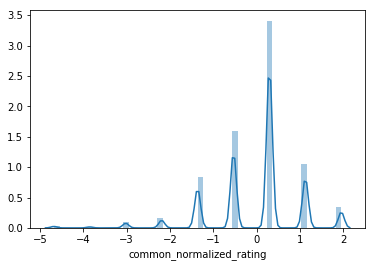

In [4]:
reviews.rating[reviews.rating.isna()]
reviews.loc[42080, 'rating'] = reviews.rating.mean() 

ratings = reviews.rating
reviews['common_normalized_rating'] = (ratings - ratings.mean())/(ratings.std())

sns.distplot(reviews['common_normalized_rating'])

/home/maria/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/maria/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/maria/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/maria/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


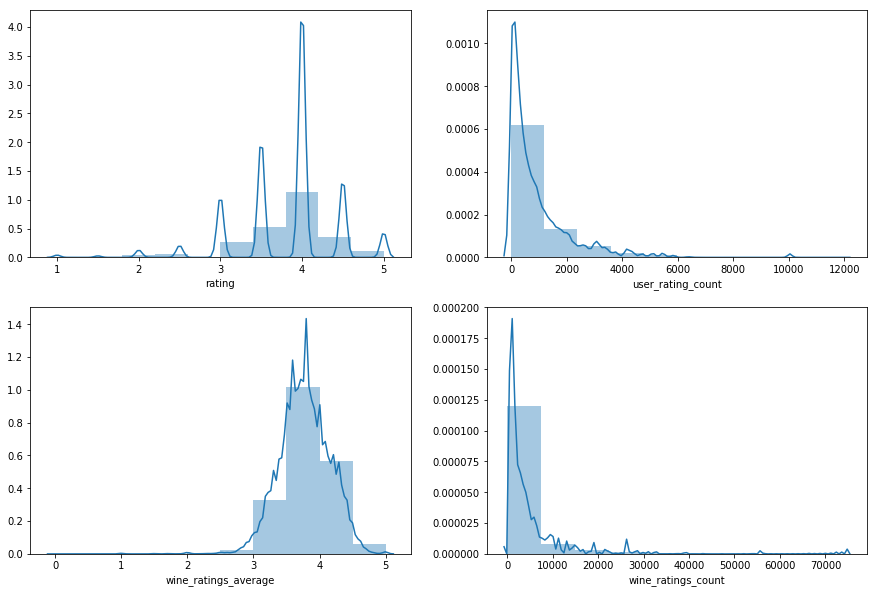

In [5]:
features = ['rating', 'user_rating_count', 'wine_ratings_average', 'wine_ratings_count']

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i in range(len(features)):
    sns.distplot(reviews[features[i]],
             label=features[i],
             bins=10,
             ax=ax[i//2][i%2])

Видно, что имеющиеся данные очень несбалансированы. Наблюдаем высокий пик в положительную сторону от нормализованной оценки, очень много оценок 4.0, средняя оценка вина также лежит в пределах 3.5-4.0. И что самое неприятное, большая часть пользователей в датасете оставила, судя по всему, очнь мало оценок. Если взглянуть подробнее, сгруппировав пользователей по числу оставленных оценок:

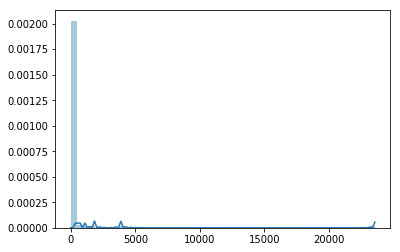

In [6]:
byUserNumRatings = reviews[['user_id', 'rating']].groupby(['user_id']).count()
    
byUserNumRatings.reset_index(level=0, inplace=True)

numUsersByNumRatings = byUserNumRatings.groupby(['rating']).count()

sns.distplot(numUsersByNumRatings)

Большая часть пользователей оставила только 1 оценку, что очень непрезентативно для построения рабочей рекомендательной системы. Такое распределение нужно учесть при разбиении датасета на обучение и выборку.

А вообще, сам вид распределения количества оценок весьма типичен, в датасетах поисковых данных очень часто большинство объектов бывает оценено малым числом пользователей. НО В ИТОГОВОМ ВАРИАНТЕ ССЫЛКУ МОЖЕШЬ НЕ ОСТАВЛЯТЬ Вот тут статья про знакомство с датасетами и правильное представление распределений (учебных) данных, которую я слишком поздно нашла: https://towardsdatascience.com/recommender-system-in-python-part-1-preparation-and-analysis-d6bb7939091e

## Предобработка данных

Объединим имеющиеся таблицы данных и посмотрим на признаки.

In [7]:
df_joined = reviews.join(wines, on='wine_id', lsuffix='_rev', rsuffix='_wine')
df_joined.dtypes

non_numeric_columns = df_joined.select_dtypes(exclude=['number']).columns.tolist()
df_joined[non_numeric_columns].describe()

,coment,lang,time,wine_name,year,country,country_code,name,region_name,style,wine_description,winery_name
count,99085,99086,99087,99087,99087,69762,69762,69762,69762,52129,49947,69762
unique,98303,30,99042,20096,90,26,26,3640,705,440,3418,1738
top,Muito bom,en,2015-01-17T20:50:11.000Z,Cabernet Sauvignon,U.V.,United States,us,Pinot Noir,Columbia Valley,"{'id': 157, 'seo_name': 'californian-pinot-noi...","Silky black cherry, cranberry and orange zest ...",Buccia
freq,15,95877,2,1488,18069,28499,28499,2268,2566,1721,880,1014


In [8]:
non_numeric_columns = df_joined.select_dtypes(exclude=['number']).columns.tolist()
numeric_columns = df_joined.select_dtypes(include=['number']).columns.tolist()

unique_values_num = df_joined.apply(pd.Series.nunique)
unique_values_non_num = df_joined[non_numeric_columns].apply(pd.Series.nunique)
print("Unique values of non numeric data:\n", unique_values_non_num)
print("Unique values of numeric data:\n", unique_values_num)

Unique values of non numeric data:
 coment              98303
lang                   30
time                99042
wine_name           20096
year                   90
country                26
country_code           26
name                 3640
region_name           705
style                 440
wine_description     3418
winery_name          1738
dtype: int64
Unique values of numeric data:
 coment                       98303
lang                            30
rating                          10
review_comments                142
review_likes                   437
time                         99042
user_follower_count           1809
user_following_count          1242
user_id                      34223
user_rating_count             2250
user_reviews_count            1967
wine_id_rev                   7628
wine_labels_count_rev         5776
wine_name                    20096
wine_ratings_average_rev        39
wine_ratings_count_rev        3238
wine_reviews_count            1125
year        

Видим, что признаков очень много, есть количественные, категориальные и текстовые столбцы, каждый из которых требует предварительной обработки. Для начала удалим дублирующие друг друга и неинформативные признаки. Отберём текстовые признаки; те числовые признаки, которые имеют мало уникальных значений и которые удобнее представить как категориальные; остальные оставим количественными.

In [9]:
df_joined.drop(['style', 'time', 'rank', 'winery_name', 'wine_name', 'country', 'name', 'region_name'], 
               axis=1, inplace=True)

text_columns = ['coment', 'wine_description']
categorical_columns = ['sweetness_id', 'type_id', 'country_code', 'lang']
numeric_columns = df_joined.select_dtypes(include=['number']).columns.tolist()
numeric_columns.remove('sweetness_id')
numeric_columns.remove('type_id')

Данные довольно грязные: нам точно не пригодится строка с отсутствующим user_id (она одна), все рейтинги без wine_id переобозначим как оценки, оставленные некоторому вину с новым id = -1. Такой OutOfVocabulary подход позволит не потерять ного данных при чистке, но и получить некоторую усредненную информацию для отсутствующих вин.

Также в реализованной функции очистки данных преобразуем в категориальный признак country_code, оставив только 6 значений (5 наиболее часто встречающихся и один "другое"). Переведём признак года вина в количественный. (КСТАТИ КАК ЕГО ИСПОЛЬЗОВАТЬ?)

In [10]:
def clean_data(data):
    data = data.drop(data[data.user_id.isna()].index)
    null_wines_idx = data[data.wine_id_wine.isna()].index
    data['wine_id_wine'].loc[null_wines_idx] = -1
    
    country_code_treshold = sorted(list(data['country_code'].value_counts()))[-5:][0]
    lang_treshold = sorted(list(data['lang'].value_counts()))[-5:][0]

    counts_country_code = data['country_code'].value_counts()
    data['country_code'].replace(counts_country_code[counts_country_code < country_code_treshold].index,
                                 'uncommon', inplace=True)
    counts_lang = data['lang'].value_counts()
    data['lang'].replace(counts_lang[counts_lang < lang_treshold].index, 'uncommon', inplace=True)

    data.year.replace('U.V.', np.NaN, inplace=True)
    data.year.replace('N.V.', np.NaN, inplace=True)
    data.year = data.year.astype(float)
    
    return data

In [11]:
import warnings

warnings.filterwarnings('ignore')
df_joined = clean_data(df_joined)

Далее необходимо правильно разделить датасет на обучение и выборку: хотим, чтобы в тест у нас отправились только те пользователи, оценки которых уже присутствуют в обучении. Так как один из используемых методов - это SVD-разложение матрицы Пользователи х Вина, такой сплит не позволит SVD сойти с ума при обнаружении не встреченного ранее пользователя в тесте.

In [12]:
def split(data, train_s=0.8):
    print("data shape:", data.shape[0])
    byUserNumRatings = reviews[['user_id', 'rating']].groupby(['user_id']).count()

    # сначала положим в обучение всех пользователей в датасете, которые поставили только одну оценку
    print("Всего пользователей: ", byUserNumRatings.shape[0])
    one_rating_users = byUserNumRatings[byUserNumRatings.rating==1].index.tolist()
    print("Пользователей с 1 оценкой: ", len(one_rating_users))
    train_data = data.loc[data['user_id'].isin(one_rating_users)]

    # для остальных поль-лей случайно выберем 1 оценку и добавим в обучение
    more_rating_users = byUserNumRatings[byUserNumRatings.rating>1].index.tolist()
    print("Пользователей с >1 оценками: ", len(more_rating_users))
    test_data = pd.DataFrame()
    
    for user in more_rating_users:
        sh = data[data.user_id==user].shape[0]
        if sh<=3:
            train_data = train_data.append(data[data.user_id==user].iloc[0])
            test_data = test_data.append(data[data.user_id==user].iloc[1:])
        elif sh<=10:
            train_data = train_data.append(data[data.user_id==user].iloc[:8])
            test_data = test_data.append(data[data.user_id==user].iloc[9:])
        else:
            prop = int(0.8*sh)
            train_data = train_data.append(data[data.user_id==user].iloc[:prop])
            test_data = test_data.append(data[data.user_id==user].iloc[prop+1:])
    # По-хорошему, конечно, необходимо перемешивать данные и разбивать случайно в каждом отдельном случае, но в 
    # данном случае для простоты пренебрежем влиянием порядка данных в датасете из предположения, что записи в 
    # нем случайны.

    print("Итоговая доля обучения: ", train_data.shape[0]/data.shape[0])
    
    return (train_data, test_data)

In [13]:
data_train, data_test = split(df_joined)

data shape: 99087
Всего пользователей:  34223
Пользователей с 1 оценкой:  23538
Пользователей с >1 оценками:  10685
Итоговая доля обучения:  0.8268188561567108


## SVD

Так как нам хочется не только предсказывать рейтинги, но и научиться в идеале рекомендовать вина пользователям,  сформулируем задачу как построение предсказаний на основе имеющейся истории взаимодействий пользователя с винами.

Для этого обратимся к методам коллабортиавной фильтрации, которые работают с матрицей взаимодействия, в нашем случае, матрицей рейтинга. Матрица эта, как правило, огромная, очень разреженная, и большинство значений отсутствует, тем более на таком несбалансированном по rating per user датасете. Посмотрим, что нам даст сырая матричная факторизация.

SVD - один из методов матричной факторизации, включающий оценку параметров с помощью стохастичекого градиентного спуска. В реализации используется библиотека surprise с множеством моделей для построения предсказаний. Для сравнения работы построенных алгоритмов будем отталкиваться от базовых оценок (BaselineOnly) и случайного нормального распределения обучающей выборки (NormalPredictor).

In [33]:
data_train_svd = data_train[['user_id', 'wine_id_wine', 'common_normalized_rating']]
data_train_svd = data_train_svd.astype({'user_id':int, 'wine_id_wine':int, 'common_normalized_rating':float})

max_rate = data_train_svd['common_normalized_rating'].values.max()
min_rate = data_train_svd['common_normalized_rating'].values.min()

reader = Reader(rating_scale=(min_rate, max_rate))
data = Dataset.load_from_df(data_train_svd, reader)
normal_est = cross_validate(NormalPredictor(), data, cv=5, n_jobs=4)
baseline_est = cross_validate(BaselineOnly(), data, cv=5, n_jobs=4)
print('Normal MAE: ', np.mean(normal_est['test_mae']), '  RMSE: ', np.mean(normal_est['test_rmse']))
print('Baseline MAE: ', np.mean(baseline_est['test_mae']), '  RMSE: ', np.mean(baseline_est['test_rmse']))

Normal MAE:  1.10786780972465   RMSE:  1.411300656151196
Baseline MAE:  0.6360893457625785   RMSE:  0.8860096567903929


SVD является одной из самой популярных методологий в построении рекомендательнх систем. Вместе с тем, качество её работы остается очень чувствительным к гиперпараметрам. Подберём их.

In [34]:
param_grid = {'n_factors': [10,30,100], 
              'n_epochs': range(10, 105, 5),
              'lr_all': [0.008, 0.009],
              'reg_all': [0.1, 0.08], 
              'init_mean': [0.0, data_train.common_normalized_rating.mean()], 
              'init_std_dev':[0.1, data_train.common_normalized_rating.std()]}
# прикинем жадным поиски оптимальные параметры для SVD на обучающей выборке
gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=4)    

gs_svd.fit(data)
bestSVD = gs_svd.best_estimator['mae']

В реализации surprise есть свои особенности применения, в частности, ограниченная система формирования test-сета. Чтобы сохранить реализованный ранее сплит и получить предсказания на обучающих и тестовых данных, просто соберем покомпонентно эти предсказания самостоятельно.

In [35]:
trainset_svd = data.build_full_trainset()
bestSVD.fit(trainset_svd)       # снова обучим лучшую по параметрам SVD, чтобы получить доступ к атрибутам 
                                # матричной факторизации: user_bias, item_bias, user_factors и item_factors

In [36]:
# запомним отображение исходных user_id и wine_id в их идентификаторы в рамках SVD-разложения
mapping_bu = trainset_svd.__dict__['_raw2inner_id_users']
mapping_bi = trainset_svd.__dict__['_raw2inner_id_items']

In [46]:
mu = data_train['common_normalized_rating'].values.mean()

def svd_predict(x):             # cложим вычисленные на обучающей выборке компоненты в стандартный прогноз SVD
    y = bestSVD.pu[mapping_bu.get(x['user_id'])]              # используем факторы пользователя
    if mapping_bi.get(x['wine_id_wine']):
        z = bestSVD.qi[mapping_bi.get(x['wine_id_wine'])]     # факторы вина
        bi = bestSVD.bi[mapping_bi.get(x['wine_id_wine'])]    # смещение по вину (bias)
    else:
        z = bestSVD.qi[mapping_bi.get(-1)]
        bi = bestSVD.bi[mapping_bi.get(-1)]
    bu = bestSVD.bu[mapping_bu.get(x['user_id'])]             # смещение по пользователю (bias)
    
    return mu + bu + bi + np.dot(y,z)                         # и также учтем среднее

res_train = data_train.apply(svd_predict, axis=1).as_matrix()
res_train

/home/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


array([ 0.2851757 , -0.38555418, -0.40498627, ...,  0.15770036,
        0.35459132,  0.00419311])

In [43]:
data_train['common_normalized_rating'].values

array([1.12413729, 0.29576268, 0.29576268, ..., 0.29576268, 0.29576268,
       0.29576268])

Уже визуально аблюдаем ощутимое расхождение. Проделаем то же самое с тестовым датасетом и посмотрим на ошибки.

In [47]:
svd_test = data_test[['user_id', 'wine_id_wine', 'common_normalized_rating']]
svd_test = svd_test.astype({'user_id':int, 'wine_id_wine':int, 'common_normalized_rating':float})

In [48]:
res_test = data_test.apply(svd_predict, axis=1).as_matrix()
res_test

/home/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([-1.55746233, -0.56233669,  0.29127084, ...,  0.18905728,
        0.13098551,  0.18878465])

In [ ]:
svd_test['common_normalized_rating'].values

Конечно, визуально оценить величину ошибки невозможно, посчитаем их для обучающего и тестового датасетов и сравним с полученными ранее BaselineOnly и NormalPredictor.

In [51]:
print('Train MAE: ', metrics.mean_absolute_error(res_train, data_train_svd['common_normalized_rating']), '  Train RMSE: ', 
      metrics.mean_squared_error(res_train, data_train_svd['common_normalized_rating']))
print('Test MAE: ', metrics.mean_absolute_error(res_test, svd_test['common_normalized_rating']), '  Test RMSE: ', 
      metrics.mean_squared_error(res_test, svd_test['common_normalized_rating']))

Train MAE:  0.4950477339738902   Train RMSE:  0.479047842654367
Test MAE:  0.5859603175972965   Test RMSE:  0.6772881283006332


Что ж, SVD предсказывает лучше, чем базовые алгоритмы, но ошибка в 0.5-0.6 от нормализованного рейтинга непростительно велика. Запомним полученный результат и добавим его для сравнения в набор признаков при обучении xgboost-а.



## Простейший xgboost с числовыми признаками

Наряду с SVD посмотрим на примитивное решение xgboost-а на основе только числовых признаков. Разделим выборки на признаки и таргет. Так как xgboost прихотлив к формату входных данных, проведем все необходимые для градиентного бустинга преобразования: заполнение пропусков и one-hot-encoding категориальных данных.

In [14]:
def make_X_y(nltk=0):
    X_train = data_train.drop(['rating', 'common_normalized_rating', 'coment', 'wine_description'], axis=1)
    X_test = data_test.drop(['rating', 'common_normalized_rating', 'coment', 'wine_description'], axis=1)
    if nltk:
        X_train = X_train.drop(['preprocessed'], axis=1)
        X_test = X_test.drop(['preprocessed'], axis=1)

    y_train = data_train['common_normalized_rating']
    y_test = data_test['common_normalized_rating']
    
    return X_train, X_test, y_train, y_test

In [15]:
X_train, X_test, y_train, y_test = make_X_y()

In [16]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    [
        ('cat', categorical_transformer, categorical_columns),
    ], remainder='passthrough'
)

In [17]:
%%time
X_train = preprocessor.fit_transform(X_train)

CPU times: user 833 ms, sys: 120 ms, total: 953 ms
Wall time: 851 ms


In [18]:
X_test = preprocessor.transform(X_test)

In [19]:
print('Обучение: ', X_train.shape, '\t\tТест: ', X_test.shape)

Обучение:  (81927, 52) 		Тест:  (15300, 52)


Ещё часто проводится нормализация количественных признаков, но так как поставлена задача регрессии и для её решения мы будем пользоваться XGB над решающими деревьями, то масштабирование данных не будет иметь значения.

Поварьируем число деревьев и посмотрим на ошибки.

In [20]:
def xgb_reg(X_train, y_train, X_test, y_test, imp_columns=df_joined.drop(['rating', 'common_normalized_rating', 
                                                                          'coment', 'wine_description'], 
                                                                         axis=1).columns):
    evals = []  
    n_trees = list(range(5, 105, 5))
    for tree in n_trees:
        warnings.filterwarnings('ignore')
        est = xgb.XGBRegressor(max_depth=15, learning_rate=0.1, objective='reg:squarederror', n_estimators=tree, 
                               n_jobs=4, random_state=42)
        est.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric=['rmse', 'mae'], 
                verbose=False)    
        importances = OrderedDict(sorted(list(zip(imp_columns, est.feature_importances_)), key=lambda st: st[1]))
        evals.append(est.evals_result())
    return evals, importances

In [31]:
evals_result, importances = xgb_reg(X_train, y_train, X_test, y_test)

In [22]:
def show_evals(result):
    for i in result:
        train_rmse = i.get('validation_0').get('rmse')
        train_mae = i.get('validation_0').get('mae')
        test_rmse = i.get('validation_1').get('rmse')
        test_mae = i.get('validation_1').get('mae')
    print(test_mae[:10])
    return train_rmse, train_mae, test_rmse, test_mae

In [23]:
train_evals_rmse, train_evals_mae, test_evals_rmse, test_evals_mae = show_evals(evals_result)

[0.724982, 0.674892, 0.635774, 0.603563, 0.576611, 0.554029, 0.534451, 0.518845, 0.505331, 0.49376]


In [24]:
def plot_compare(data1, label1, data2, label2, data3=None, label3=None, data4=None, label4=None, data5=None, 
                 label5=None, data6=None, label6=None, data7=None, label7=None, data8=None, label8=None,):
    plt.figure(1, figsize=(15,5))
    plt.subplot(121)
    plt.plot(range(len(data1)), data1, label=label1)
    plt.plot(range(len(data2)), data2, label=label2)
    if data5:
        plt.plot(range(len(data5)), data5, label=label5)
    if data6:
        plt.plot(range(len(data6)), data6, label=label6)
        

    plt.grid(True)
    plt.xlabel('n_trees')
    plt.ylabel('score')
    title_name = label1.split()
    plt.title(title_name[1])
    plt.legend(loc='upper right')

    plt.subplot(122)
    plt.plot(range(len(data3)), data3, label=label3)
    plt.plot(range(len(data4)), data4, label=label4)
    if data7:
        plt.plot(range(len(data7)), data7, label=label7)
    if data8:
        plt.plot(range(len(data8)), data8, label=label8)

    plt.grid(True)
    plt.xlabel('n_trees')
    plt.ylabel('score')
    title_name = label3.split()
    plt.title(title_name[1])
    plt.legend(loc='upper right')

    plt.show()

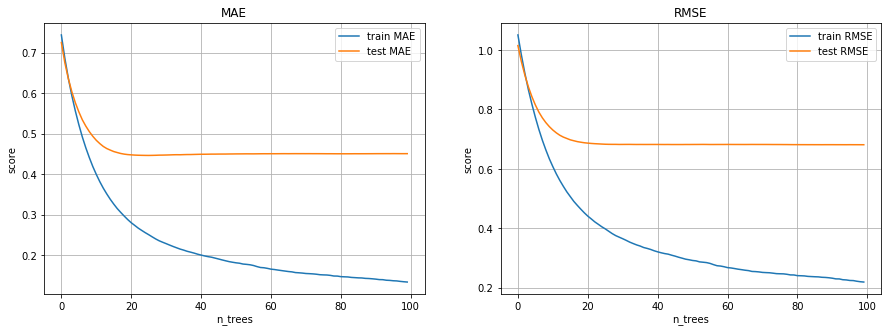

In [25]:
plot_compare(train_evals_mae, 'train MAE', test_evals_mae, 'test MAE', train_evals_rmse, 'train RMSE', test_evals_rmse,
            'test RMSE')

Судя по всему, большое число деревьев не улучшает качество предсказаний, так как после 30 ошибка на тестовых данных перестает значительно падать. Это неудивительно, едь датасет не такой уж и большой.

Между тем, определим признаки, оказывающие наибольшее влияние на предсказание.

<BarContainer object of 33 artists>

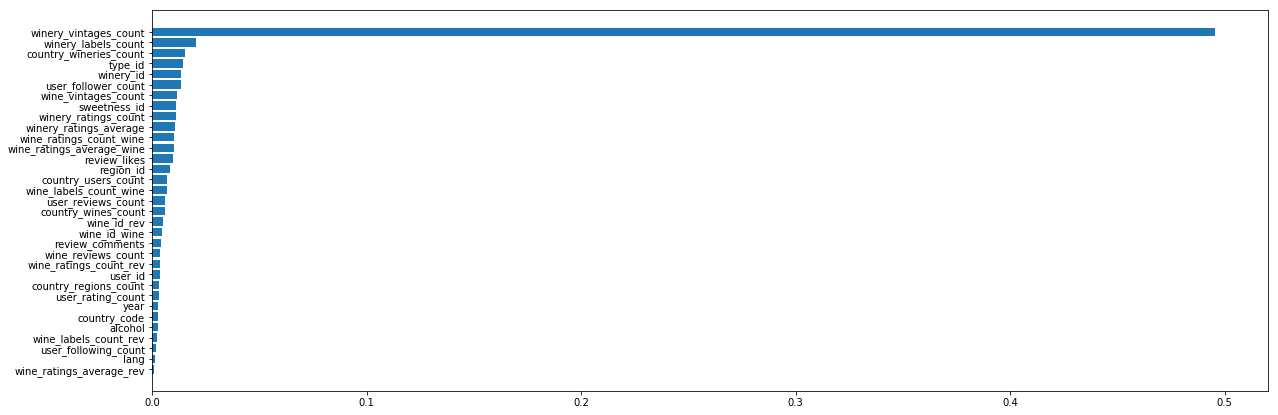

In [42]:
fig = plt.figure(figsize=(20, 7))
plt.barh(*zip(*sorted(importances.items(), key=lambda x:x[1])))

Таким образом, получили, что xgboost оказывается несколько точнее по сравнению с SVD, даже без использования всех признаков, таких как текст и параметры SVD-разложения.

Посмотрим, как изменится качество предсказаний при добавлении некоторых атрибутов матричной факторизации к признакам.

## SVD++    (SVDpp)

Библиотека surprise предлагает нам более интересный алгоритм матричной факторизации, который позволяет учитывать набор факторов, отражающий неявные рейтинги (как, например, сам факт того, что пользователь оценил данное вино). Обучим его.

In [43]:
# выбираем данные для матрицы Пользователи х Вина
data_train_svd = data_train[['user_id', 'wine_id_wine', 'common_normalized_rating']]
data_train_svd = data_train_svd.astype({ 'user_id':int, 'wine_id_wine':int,'common_normalized_rating':float})
svd_test = data_test[['user_id', 'wine_id_wine', 'common_normalized_rating']]
svd_test = svd_test.astype({ 'user_id':int, 'wine_id_wine':int,'common_normalized_rating':float})

# устанавливаем границы таргета
max_rate = data_train_svd['common_normalized_rating'].values.max()
min_rate = data_train_svd['common_normalized_rating'].values.min()

# заводим специальные объекты для обработки SVD++, подбираем параметры на обучающей выборке
reader = Reader(rating_scale=(min_rate, max_rate))
data = Dataset.load_from_df(data_train_svd, reader)

param_grid_svdpp = {'n_epochs': range(30, 70, 5), 'lr_all': [0.009], 'reg_all': [0.08]}

gs_svdpp = GridSearchCV(SVDpp, param_grid_svdpp, measures=['rmse','mae'], cv=5, n_jobs=4)
gs_svdpp.fit(data)
bestSVDpp = gs_svdpp.best_estimator['mae']

In [44]:
# обучаем модель на обучающей выборке
trainset_svdpp = data.build_full_trainset()
bestSVDpp.fit(trainset_svdpp)

In [45]:
# получим новые отображения
mapping_bu_pp = trainset_svdpp.__dict__['_raw2inner_id_users']
mapping_bi_pp = trainset_svdpp.__dict__['_raw2inner_id_items']

In [46]:
bu = bestSVDpp.bu[data_train['user_id'].map(mapping_bu_pp)]
bi = bestSVDpp.bi[data_train['wine_id_wine'].map(mapping_bi_pp)]
yj = bestSVDpp.yj[data_train['wine_id_wine'].map(mapping_bi_pp)]

bu_test = bestSVDpp.bu[data_test['user_id'].map(mapping_bu_pp)]

# с wine_bias-ами придется повозиться, так как в тесте могут быть wine_id, не встретившиеся в обучении. 
wine_map = data_test['wine_id_wine'].map(mapping_bi_pp)    
wine_map[wine_map.isna()] = mapping_bi_pp.get(-1)   # переобозначим их за наше OutOfVocabulary id=-1
wine_map = wine_map.astype(int)
bi_test = bestSVDpp.bi[wine_map]
yj_test = bestSVDpp.yj[wine_map]

In [48]:
def svd_scalar_map_pp(x):                                 # аналогично соберём компоненты разложения - скалярное 
    y = bestSVDpp.pu[mapping_bu_pp.get(x['user_id'])]     # произведение факторов пользователя на факторы вина
    if mapping_bi_pp.get(x['wine_id_wine']):
        z = bestSVDpp.qi[mapping_bi_pp.get(x['wine_id_wine'])]
    else:
        z = bestSVDpp.qi[mapping_bi_pp.get(-1)]
    return np.dot(y,z)
    
scalar = data_train.apply(svd_scalar_map_pp, axis=1).as_matrix()
scalar_test = data_test.apply(svd_scalar_map_pp, axis=1).as_matrix()

In [49]:
def svd_sum(x):                                              # и сумму скалярного произведения и смещений
    u = bestSVDpp.bu[mapping_bu_pp.get(x['user_id'])]
    if mapping_bi_pp.get(x['wine_id_wine']):
        i = bestSVDpp.bi[mapping_bi_pp.get(x['wine_id_wine'])]
    else:
        i = bestSVDpp.bi[mapping_bi_pp.get(-1)]
    sc = svd_scalar_map_pp(x)
    return (u + i + sc)

svd_sum_train = data_train.apply(svd_sum, axis=1).as_matrix()
svd_sum_test = data_test.apply(svd_sum, axis=1).as_matrix()

In [46]:
X_train, X_test, y_train, y_test = make_X_y()

In [47]:
X_train['user_bias'] = pd.Series(bu, index=X_train.index)   # будем добавлять полученные компоненты к признакам для
X_train['wine_bias'] = pd.Series(bi, index=X_train.index)   # обучения, начнем с bias-ов.

X_test['user_bias'] = pd.Series(bu_test, index=X_test.index)
X_test['wine_bias'] = pd.Series(bi_test, index=X_test.index)

imp_columns = X_train.columns

In [48]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print('Обучение: ', X_train.shape, 'Тест: ', X_test.shape)

Обучение:  (81927, 54) Тест:  (15300, 54)


In [49]:
evals_result_bias, importances_bias = xgb_reg(X_train, y_train, X_test, y_test, imp_columns)

In [50]:
train_evals_rmse_bias, train_evals_mae_bias, test_evals_rmse_bias, test_evals_mae_bias = show_evals(evals_result_bias)

[0.72936, 0.684601, 0.649875, 0.621958, 0.598084, 0.577831, 0.560961, 0.54714, 0.535767, 0.526357]


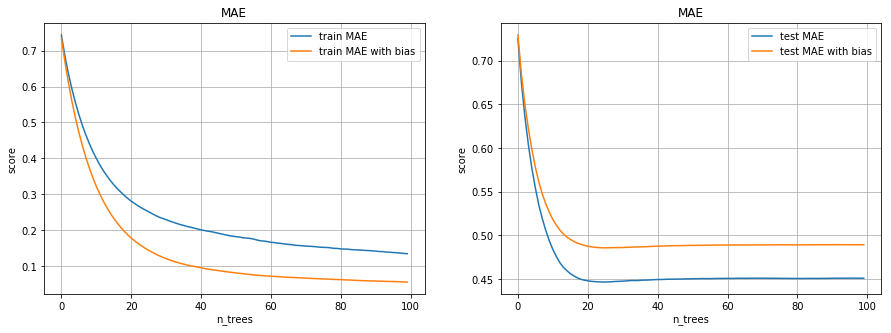

In [51]:
plot_compare(train_evals_mae, 'train MAE', train_evals_mae_bias, 'train MAE with bias', test_evals_mae, 'test MAE', 
             test_evals_mae_bias, 'test MAE with bias')

На графиках наглядно показано, как быстро переобучается модель при добавлении bias-ов (ещё даже не суммы компонент SVD-разложения): на обучающей выборке xgboost показывает заметно лучший результат, а на тестовой всегда проигрывает простейшем обучении на числовых данных. Очевидно, алгоритмы слишком настраиваются на конкртеный набор данных.

Посмотрим, станут ли предсказания лучше при добавлении скалярного произведения факторов пользователя на факторы вин - основы предсказания SVD.

In [52]:
X_train, X_test, y_train, y_test = make_X_y()

X_train['svd_scalar'] = pd.Series(scalar, index=X_train.index)
X_test['svd_scalar'] = pd.Series(scalar_test, index=X_test.index)

imp_columns = X_train.columns

In [53]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print('Обучение: ', X_train.shape, 'Тест: ', X_test.shape)

Обучение:  (81927, 53) Тест:  (15300, 53)


In [54]:
evals_result_scalar, importances_scalar = xgb_reg(X_train, y_train, X_test, y_test, imp_columns)

[0.730953, 0.687355, 0.653345, 0.625649, 0.602593, 0.583181, 0.566238, 0.551826, 0.539618, 0.529466]


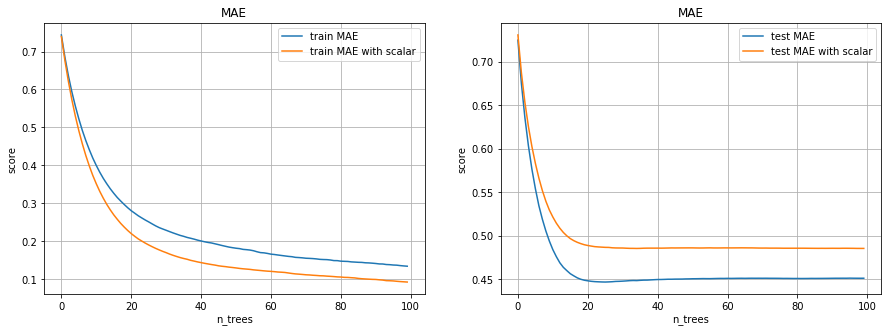

In [56]:
train_evals_rmse_scalar, train_evals_mae_scalar, test_evals_rmse_scalar, test_evals_mae_scalar = show_evals(evals_result_scalar)
plot_compare(train_evals_mae, 'train MAE', train_evals_mae_scalar, 'train MAE with scalar', test_evals_mae, 
             'test MAE', test_evals_mae_scalar, 'test MAE with scalar')

Наблюдаем очень схожие результаты. И при добавлении самого предсказания (суммы смещение по пользователям и винам и скалярного произведения факторов):

In [50]:
X_train, X_test, y_train, y_test = make_X_y()

X_train['svd_sum'] = pd.Series(svd_sum_train, index=X_train.index)
X_test['svd_sum'] = pd.Series(svd_sum_test, index=X_test.index)

imp_columns = X_train.columns

In [51]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print('Обучение: ', X_train.shape, '\t\tТест: ', X_test.shape)

Обучение:  (81927, 53) 		Тест:  (15300, 53)


In [52]:
evals_result_sum, importances_sum = xgb_reg(X_train, y_train, X_test, y_test, imp_columns)

[0.731464, 0.688358, 0.655831, 0.629094, 0.607043, 0.587414, 0.57116, 0.55737, 0.545519, 0.535743]


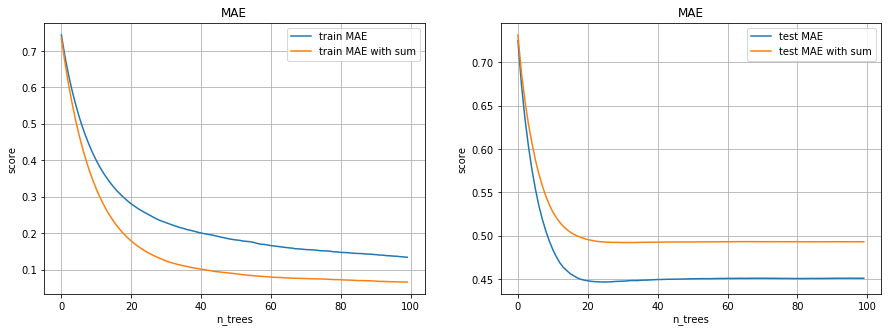

In [53]:
train_eval_rmse_sum, train_eval_mae_sum, test_eval_rmse_sum, test_eval_mae_sum = show_evals(evals_result_sum)
plot_compare(train_evals_mae, 'train MAE', train_eval_mae_sum, 'train MAE with sum', test_evals_mae, 'test MAE', 
             test_eval_mae_sum, 'test MAE with sum')

<BarContainer object of 34 artists>

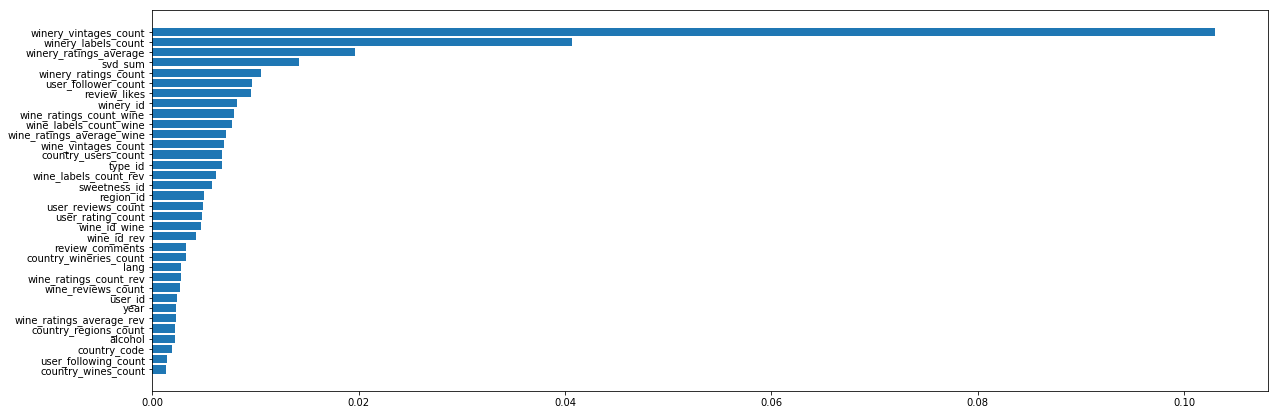

In [54]:
fig = plt.figure(figsize=(20, 7))
plt.barh(*zip(*sorted(importances_sum.items(), key=lambda x:x[1])))

Результат по сути тот же: графикам отчетливо видно, как при добавлении в признаки какого-либо атрибута SVD-разложения улучшается качество предсказаний на обучении и ухудшается на тесте, - на лицо переобучение. Очевидно, xgboost выучивает много лишнего, подробнее о том, почему так происходит, написано ниже.

## Усечение SVD++

Чтобы попытаться исправить сложившуюся картину, проведем отбор в данных для матричной факторизации: будем настраиваться на пользователей, оставивших не меньше одной оценки. Для определенности и ускорения работы SVD++ оставим в OutOfVocabulary небольшую часть пользователей. Опять же, по-хорошему, нужно выборку перемешать, выбрать пользователей случайно или по их средним оценкам, но для простоты возьмём просто группку с 4 оценками.

In [56]:
# проведём отбор данных для SVD++

more_rating_users = byUserNumRatings[byUserNumRatings.rating>=5].user_id.tolist()
ne_rating_users = byUserNumRatings[byUserNumRatings.rating==4].user_id.tolist()
print("Пользователей с >5 оценками: ", len(more_rating_users))
print("Пользователей с 4 оценками(OOV): ", len(ne_rating_users))
svd_data = data_train[data_train.user_id.isin(more_rating_users)][['user_id', 'wine_id_wine', 'common_normalized_rating']]
svd_data = svd_data.append(data_train[data_train.user_id.isin(ne_rating_users)][['user_id', 'wine_id_wine', 
                                                                                 'common_normalized_rating']])

svd_data.loc[svd_data['user_id'].isin(ne_rating_users), 'user_id'] = 1
svd_data = svd_data.astype({ 'user_id':int, 'wine_id_wine':int,'common_normalized_rating':float})

svd_test = data_test[['user_id', 'wine_id_wine', 'common_normalized_rating']]
svd_test = svd_test.astype({ 'user_id':int, 'wine_id_wine':int,'common_normalized_rating':float})

Пользователей с >5 оценками:  3794
Пользователей с 4 оценками(OOV):  1162


In [57]:
max_rate = svd_data['common_normalized_rating'].values.max()
min_rate = svd_data['common_normalized_rating'].values.min()

reader = Reader(rating_scale=(min_rate, max_rate))
data = Dataset.load_from_df(svd_data, reader)
trainset_svdpp_upd = data.build_full_trainset()

bestSVDpp = SVDpp(n_factors=10, n_epochs=55, lr_all=0.008, reg_all=0.08, init_mean=0.0, init_std_dev=0.1)
bestSVDpp.fit(trainset_svdpp_upd)

In [58]:
mapping_bu_pp_upd = trainset_svdpp_upd.__dict__['_raw2inner_id_users']
mapping_bi_pp_upd = trainset_svdpp_upd.__dict__['_raw2inner_id_items']

In [59]:
# теперь данные отображения исходных id нужно проверять на OutOfVocabulary и присваивать соответствующие значения

user_map_upd = data_train['user_id'].map(mapping_bu_pp_upd)
user_map_upd[user_map_upd.isna()] = mapping_bu_pp_upd.get(1)
user_map_upd = user_map_upd.astype(int)
bu_upd = bestSVDpp.bu[user_map_upd]

wine_map_upd = data_train['wine_id_wine'].map(mapping_bi_pp_upd)
wine_map_upd[wine_map_upd.isna()] = mapping_bi_pp_upd.get(-1)
wine_map_upd = wine_map_upd.astype(int)
bi_upd = bestSVDpp.bi[wine_map_upd]

In [60]:
user_map_upd_test = data_test['user_id'].map(mapping_bu_pp_upd)
user_map_upd_test[user_map_upd_test.isna()] = mapping_bu_pp_upd.get(1)
user_map_upd_test = user_map_upd_test.astype(int)
bu_upd_test = bestSVDpp.bu[user_map_upd_test]

wine_map_upd_test = data_test['wine_id_wine'].map(mapping_bi_pp_upd)
wine_map_upd_test[wine_map_upd_test.isna()] = mapping_bi_pp_upd.get(-1)
wine_map_upd_test = wine_map_upd_test.astype(int)
bi_upd_test = bestSVDpp.bi[wine_map_upd_test]

In [61]:
def svd_scalar_map_pp_upd(x):                                      # считаем скалярное произведение факторов
    if mapping_bu_pp_upd.get(x['user_id']):
        y = bestSVDpp.pu[mapping_bu_pp_upd.get(x['user_id'])]
    elif mapping_bu_pp_upd.get(x['user_id'])==0:
        y = bestSVDpp.pu[mapping_bu_pp_upd.get(x['user_id'])]
    else: 
        y = bestSVDpp.pu[mapping_bu_pp_upd.get(1)]
        
    if mapping_bi_pp_upd.get(x['wine_id_wine']):
        z = bestSVDpp.qi[mapping_bi_pp_upd.get(x['wine_id_wine'])]
    elif mapping_bi_pp_upd.get(x['wine_id_wine'])==0:
        z = bestSVDpp.qi[mapping_bi_pp_upd.get(x['wine_id_wine'])]
    else:
        z = bestSVDpp.qi[mapping_bi_pp_upd.get(-1)]
        
    return np.dot(y,z)
    
scalar = data_train.apply(svd_scalar_map_pp_upd, axis=1).as_matrix()
scalar_test = data_test.apply(svd_scalar_map_pp_upd, axis=1).as_matrix()

In [62]:
mu = data_train['common_normalized_rating'].values.mean()         # вычисляем средний рейтинг на обучающей выборке

# реализуем предсказание SVD++: помимо сложения смещений по пользователю и вину и скалярного gроизведения факторов
# учтем неявные факторы (посчитанные по винам, которые пользователь оценил ранее)
def svd_plusplus(x):                                              
    us = x['user_id']                                             
    if svd_data[svd_data.user_id==us].empty:                              # здесь получаем набор вин, оцененных 
        Iu = svd_data[svd_data.user_id==1].wine_id_wine.values.tolist()   # пользователем и их число
        mod_Iu = np.power(len(Iu), -0.5)                                  
    else: 
        Iu = svd_data[svd_data.user_id==us].wine_id_wine.values.tolist()
        mod_Iu = np.power(len(Iu), -0.5)
    yj = 0
    for j in Iu:                                                          # получаем неявные факторы по ним для
        yj += bestSVDpp.yj[mapping_bi_pp_upd.get(j)]                      # пользователей
    yj = yj*mod_Iu
    if mapping_bu_pp_upd.get(x['user_id']):                               # учитываем неявные факторы с общими
        y = bestSVDpp.pu[mapping_bu_pp_upd.get(x['user_id'])] + yj        # факторами пользователей, получаем
        bu = bestSVDpp.bu[mapping_bu_pp_upd.get(x['user_id'])]            # смещение по пользователю
    elif mapping_bu_pp_upd.get(x['user_id'])==0:                          # (помним, что id м.б. OutOfVocabulary)
        y = bestSVDpp.pu[mapping_bu_pp_upd.get(x['user_id'])] + yj
        bu = bestSVDpp.bu[mapping_bu_pp_upd.get(x['user_id'])]
    else: 
        y = bestSVDpp.pu[mapping_bu_pp_upd.get(1)] + yj
        bu = bestSVDpp.bu[mapping_bu_pp_upd.get(1)]
    if mapping_bi_pp_upd.get(x['wine_id_wine']):                          # получаем факторы вина и смещение по 
        z = bestSVDpp.qi[mapping_bi_pp_upd.get(x['wine_id_wine'])]        # вину
        bi = bestSVDpp.bi[mapping_bi_pp_upd.get(x['wine_id_wine'])]
    elif mapping_bi_pp_upd.get(x['wine_id_wine'])==0:
        z = bestSVDpp.qi[mapping_bi_pp_upd.get(x['wine_id_wine'])]
        bi = bestSVDpp.bi[mapping_bi_pp_upd.get(x['wine_id_wine'])]
    else:
        z = bestSVDpp.qi[mapping_bi_pp_upd.get(-1)]
        bi = bestSVDpp.bi[mapping_bi_pp_upd.get(-1)]
    return mu + bu + bi + np.dot(y,z)                                     # выдаём скалярное произведение факторов
                                                                          # с поправкой на среднее и смещения как 
                                                                          # результат

res_train = data_train.apply(svd_plusplus, axis=1).as_matrix()
res_test = data_test.apply(svd_plusplus, axis=1).as_matrix()

In [63]:
print('Train MAE: ', metrics.mean_absolute_error(res_train, data_train['common_normalized_rating']),
      '\tTrain RMSE: ', metrics.mean_squared_error(res_train, data_train['common_normalized_rating']))
print('Test MAE: ', metrics.mean_absolute_error(res_test, data_test['common_normalized_rating']), '\tTest RMSE: ', 
      metrics.mean_squared_error(res_test, data_test['common_normalized_rating']))

Train MAE:  0.564142154375844 	Train RMSE:  0.6718511523017839
Test MAE:  0.5866675461032429 	Test RMSE:  0.6921062058932866


Качество предсказаний совсем не улучшается, неудивительно, ведь мы сильно сократили датасет и участвующих в нем пользователей. Посмотрим на влияние факторов на xgboost.

## XGBoost с параметрами SVD-разложения

In [64]:
X_train, X_test, y_train, y_test = make_X_y()

X_train['user_bias'] = pd.Series(bu_upd, index=X_train.index)
X_train['wine_bias'] = pd.Series(bi_upd, index=X_train.index)
X_test['user_bias'] = pd.Series(bu_upd_test, index=X_test.index)
X_test['wine_bias'] = pd.Series(bi_upd_test, index=X_test.index)

imp_columns = X_train.columns

In [65]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print('Обучение: ', X_train.shape, '\t\tТест: ', X_test.shape)

Обучение:  (81927, 54) 		Тест:  (15300, 54)


In [66]:
evals_result_upd_bias, importances_upd_bias = xgb_reg(X_train, y_train, X_test, y_test, imp_columns)

[0.724862, 0.675614, 0.636364, 0.604471, 0.577541, 0.554791, 0.53563, 0.519248, 0.505064, 0.493024]


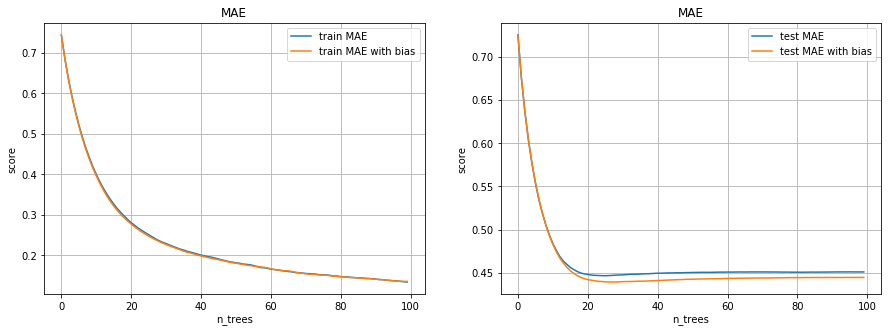

In [67]:
train_rmse_upd_bias, train_mae_upd_bias, test_rmse_upd_bias, test_mae_upd_bias = show_evals(evals_result_upd_bias)
plot_compare(train_evals_mae, 'train MAE', train_mae_upd_bias, 'train MAE with bias', test_evals_mae, 'test MAE', 
             test_mae_upd_bias, 'test MAE with bias')

In [68]:
X_train, X_test, y_train, y_test = make_X_y()

X_train['svd_scalar'] = pd.Series(scalar, index=X_train.index)
X_test['svd_scalar'] = pd.Series(scalar_test, index=X_test.index)

imp_columns = X_train.columns

In [69]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print('Обучение: ', X_train.shape, 'Тест: ', X_test.shape)

Обучение:  (81927, 53) Тест:  (15300, 53)


In [70]:
evals_result_upd_scal, importances_upd_scal = xgb_reg(X_train, y_train, X_test, y_test, imp_columns)

[0.726559, 0.679004, 0.642395, 0.611693, 0.5857, 0.564194, 0.545698, 0.530009, 0.516805, 0.505274]


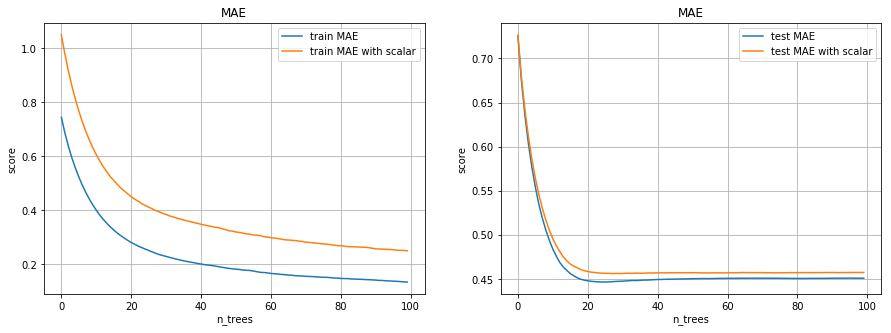

In [71]:
train_rmse_upd_scal, train_mae_upd_scal, test_rmse_upd_scal, test_mae_upd_scal = show_evals(evals_result_upd_scal)
plot_compare(train_evals_mae, 'train MAE', train_rmse_upd_scal, 'train MAE with scalar', test_evals_mae, 
             'test MAE', test_mae_upd_scal, 'test MAE with scalar')

In [72]:
X_train, X_test, y_train, y_test = make_X_y()

X_train['svd_sum'] = pd.Series(res_train, index=X_train.index)
X_test['svd_sum'] = pd.Series(res_test, index=X_test.index)

imp_columns = X_train.columns

In [73]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print('Обучение: ', X_train.shape, 'Тест: ', X_test.shape)

Обучение:  (81927, 53) Тест:  (15300, 53)


In [74]:
evals_result_upd_sum, importances_upd_sum = xgb_reg(X_train, y_train, X_test, y_test, imp_columns)

[0.727728, 0.680097, 0.642431, 0.61193, 0.586128, 0.563719, 0.54484, 0.52887, 0.515418, 0.503722]


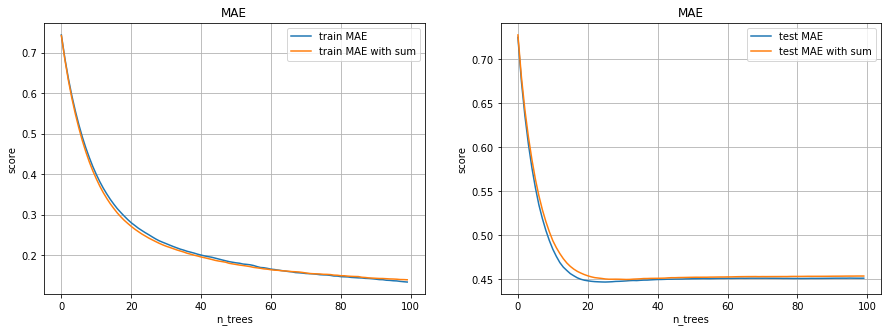

In [75]:
train_rmse_upd_sum, train_mae_upd_sum, test_rmse_upd_sum, test_mae_upd_sum = show_evals(evals_result_upd_sum)
plot_compare(train_evals_mae, 'train MAE', train_mae_upd_sum, 'train MAE with sum', test_evals_mae, 'test MAE', 
             test_mae_upd_sum, 'test MAE with sum')

<BarContainer object of 34 artists>

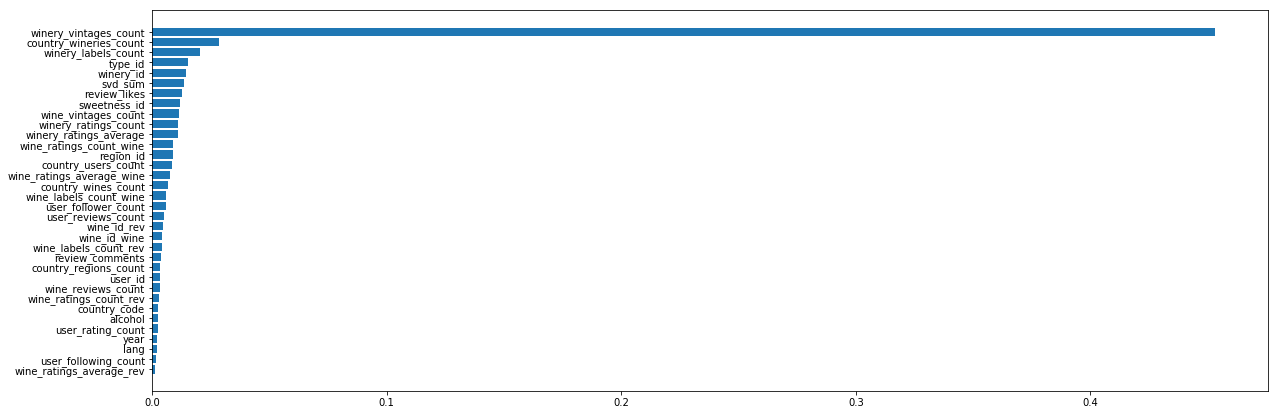

In [76]:
fig = plt.figure(figsize=(20, 7))
plt.barh(*zip(*sorted(importances_upd_sum.items(), key=lambda x:x[1])))

Результаты показывают, что строгое отсечение пользователей со слишком короткой историей взаимодействия показывает не лучшее качество, чем xgboost, обученный только на числовых признаках, но и не переобучается так сильно, как при обучении на сырых данных. Тем не менее, добавление параметров матричной факторизации не дает заметного улучшения качества предсказаний, и, похоже, в этой задаче SVD нам не товарищ. Можно было бы, пожалуй, ещё позаниматься отбором  выборки для SVD++, но это скорее всего не даст нам особого прироста, а данные будут ещё более синтетическими. 

Однако у нас есть ещё неиспользованные текстовые признаки, которые несут в себе немало информации для предсказания оценки. Остаётся прибегнуть к анализу текстов.

## Tf-IDF

С помощью меры tf-idf выделим наиболее важные (весомые) слова среди плохих и хороших отзывов. Так у нас появится срез слов, которые будут отражать позитивные и негативные нюансы текстового описания вина. Добавление информации о вхождении этих в слов в отзыв должен повысит качество предсказаниясамой оценки.

Тут мы, конечно, лукавим, так как в реальности у нас никогда не будет возможности посмотреть на отзыв отдельно от оценки, и такой подход всё-таки является заглядыванием в будущее. Тем не менее, интересно будет посмотреть на такую искусственную модель.

Возьмём хорошо оцененные вина и объединим их текстовое описание для каждого пользователя. Делается это исходя из того, что tf-idf взвешивается лучше на больших корпусах текста.

In [114]:
df3 = data_train[data_train['rating'] > 4.5][['user_id', 'wine_id_wine', 'wine_description', 'coment']]
df3.dropna(subset=['wine_id_wine', 'coment'], inplace=True)

df_good_user_coments = df3.groupby('user_id').agg({'coment': ' '.join})
df_good_user_coments.head()

,coment
user_id,
2954.0,Celebrating the 70th anniversary of the libera...
8868.0,Spicy and full. Really good!
8968.0,Non vintaged (yes yes)\noutstanding winy champ...
24200.0,A magnificent magnum purchased 7 years ago. Ve...
28125.0,Dark fruit intensive with oak-driven flavours....


In [115]:
from langdetect import detect
import re 
RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)

min_symbols = 10
def detectLanguage(text):
    filtered = RE_EMOJI.sub(r'', text[0])        # remove emodzi
    try:
        if(len(filtered) < min_symbols):
            return "unknown"
        else:
            return detect(filtered)
    except:
        return "unknown"

df_good_user_coments["lang"] = df_good_user_coments[['coment']].apply(detectLanguage, axis=1)

In [116]:
df_good_user_coments.lang.value_counts()[:8]

en         3031
af           65
pt           38
unknown      35
es           30
fr           26
it           24
nl           19
Name: lang, dtype: int64

In [117]:
import string
import nltk

def text_preprocess(row):
    # приводим все слова к тексте к маленьким буквам
    row = row.lower()
    # вырезаем пунктуацию - переводим все знаки в пустую строку с пом. str.translate
    table = str.maketrans('', '', string.punctuation)
    row = row.translate(table)
    # переводим все числа в слово num(оно более информативно для анализа) регулярными выражениями
    row = re.sub(r'\d+', 'num', row)
    # удаляем смайлики
    row =  RE_EMOJI.sub(r'', row)     
    
    # из nltk заимствуем стоп-лист слов, переводим его в множество для ускорения
    # НО! Если посмотреть на стоп-лист внимательнее, обнаружим там отрицательные частицы типа "не". Их обязательно
    # нужно оставить, так как мы хотим в дальнейшем получить 1- и 2-граммы для плохих отзывов
    stopwords = set(nltk.corpus.stopwords.words('english') + ['reuter', '\x03'])
    not_stopwords = {'not', 'no', 'nor'} 
    final_stop_words = set([word for word in stopwords if word not in not_stopwords])

    row = [word for word in row.split() if word not in final_stop_words]
    
    # стеммируем очищенный текст
    stemmer = nltk.stem.PorterStemmer()
    row = [" ".join([stemmer.stem(word) for word in row])]
    return row[0]

In [118]:
df_good_user_coments = df_good_user_coments[df_good_user_coments.lang=='en']

In [119]:
df_good_user_coments['preprocessed'] = df_good_user_coments['coment'].apply(text_preprocess)

In [120]:
df_good_user_coments.head()

,coment,lang,preprocessed
user_id,,,
2954.0,Celebrating the 70th anniversary of the libera...,en,celebr numth anniversari liber denmark candl w...
8868.0,Spicy and full. Really good!,en,spici full realli good
8968.0,Non vintaged (yes yes)\noutstanding winy champ...,en,non vintag ye ye outstand wini champagn non so...
24200.0,A magnificent magnum purchased 7 years ago. Ve...,en,magnific magnum purchas num year ago soft matu...
28125.0,Dark fruit intensive with oak-driven flavours....,en,dark fruit intens oakdriven flavour rich dens ...


Векторизуем полученные корпуса, ищем слова и пары слов. Сразу отсечём слишком часто встречающиеся, а значит неинформативные слова и словосочетания.

In [121]:
vect = TfidfVectorizer(ngram_range=(1,2), max_df=0.8, min_df=1)

In [122]:
%%time
good_coment_vectorized = vect.fit_transform(df_good_user_coments['preprocessed'])

CPU times: user 178 ms, sys: 293 µs, total: 178 ms
Wall time: 177 ms


In [123]:
good_coment_vectorized

<3031x41168 sparse matrix of type '<class 'numpy.float64'>'
	with 96099 stored elements in Compressed Sparse Row format>

In [124]:
good_words_list = vect.get_feature_names()
good_com_arr = good_coment_vectorized.toarray()
good_words_stat = []        

for i in range(good_com_arr.shape[1]):
    meet = [j for j in good_com_arr[:,i] if j!=0]
    num_meet = len(meet)
    mean_tfidf = np.sum(meet)/num_meet
    if num_meet > 20:                
        good_words_stat.append((good_words_list[i], num_meet, mean_tfidf))
good_words_stat = sorted(good_words_stat, key=lambda x: (-x[2], -x[1]))

Возьмём 20 самых важных слов (предварительно указав, что они должны встречаться не менее, чем в 20 документах - частотность тоже решает!).

In [125]:
print(len(good_words_stat))
top_good_words = good_words_stat[:20]
print(top_good_words)

468
[('sweet fruiti', 25, 0.36862835850310616), ('fruiti sweet', 22, 0.36357244835954294), ('good wine', 35, 0.302092604228855), ('not dri', 36, 0.29949352952745156), ('favorit wine', 32, 0.2969326908197458), ('great tast', 22, 0.28966207138428124), ('one favorit', 63, 0.2751887125681149), ('yummi', 23, 0.26998858321803143), ('fruiti not', 21, 0.25944140581989933), ('sweet not', 34, 0.2583710658257779), ('excel wine', 25, 0.2574658697773551), ('love wine', 44, 0.25431438315307503), ('great valu', 22, 0.2502643340160357), ('easi drink', 60, 0.2446784632699798), ('tasti', 43, 0.2427760030727076), ('not sweet', 65, 0.23287676818426076), ('refresh', 90, 0.2324237508184023), ('sweet wine', 27, 0.22893701584129744), ('white wine', 27, 0.22697946695859092), ('new year', 23, 0.2234812699474656)]


Топ слов выглядит убедительно: много слов и словосочетаний с позитивной оценкой. Немного выбивается из стройного ряда эпитетов "not dri", но вне контекста отзыва сложно идентифицировать, что отражает эта пара слов.

Получим такой же анти-топ важных слов для плохих отзывов.

In [126]:
df4 = data_train[data_train['rating'] < 3][['user_id', 'wine_id_wine', 'wine_description', 'coment']]
df4.dropna(subset=['wine_id_wine', 'coment'], inplace=True)

df_bad_user_coments = df4.groupby('user_id').agg({'coment': ' '.join})
df_bad_user_coments.head()

,coment
user_id,
2764.0,"Dark fruit character, evident residual sugar, ..."
3299.0,"Lacking, thin, monotone."
16274.0,Fresh fruit and Medium body. Ok finish. Fresh ...
16603.0,Not sure if it was Wine !!! Not pleasant
19696.0,Not a bad little wine. Low cost; it doesn't re...


In [127]:
df_bad_user_coments["lang"] = df_bad_user_coments[['coment']].apply(detectLanguage, axis=1)
df_bad_user_coments.lang.value_counts()[:8]

en         2269
pt           59
es           51
af           50
unknown      37
it           35
no           28
nl           23
Name: lang, dtype: int64

In [128]:
df_bad_user_coments = df_bad_user_coments[df_bad_user_coments.lang=='en']
df_bad_user_coments['preprocessed'] = df_bad_user_coments['coment'].apply(text_preprocess)
df_bad_user_coments.head()

,coment,lang,preprocessed
user_id,,,
2764.0,"Dark fruit character, evident residual sugar, ...",en,dark fruit charact evid residu sugar high alco...
3299.0,"Lacking, thin, monotone.",en,lack thin monoton
16274.0,Fresh fruit and Medium body. Ok finish. Fresh ...,en,fresh fruit medium bodi ok finish fresh light ...
16603.0,Not sure if it was Wine !!! Not pleasant,en,not sure wine not pleasant
19696.0,Not a bad little wine. Low cost; it doesn't re...,en,not bad littl wine low cost doesnt realli tast...


In [129]:
%%time
bad_coment_vectorized = vect.fit_transform(df_bad_user_coments['preprocessed'].values)

CPU times: user 151 ms, sys: 0 ns, total: 151 ms
Wall time: 149 ms


In [130]:
bad_words_list = vect.get_feature_names()
bad_com_arr = bad_coment_vectorized.toarray()
bad_words_stat = []            

for i in range(bad_com_arr.shape[1]):
    meet = [j for j in bad_com_arr[:,i] if j!=0]
    num_meet = len(meet)
    mean_tfidf = np.sum(meet)/num_meet
    if num_meet > 20:                
        bad_words_stat.append((bad_words_list[i], num_meet, mean_tfidf))
bad_words_stat = sorted(bad_words_stat, key=lambda x: (-x[2], -x[1]))

In [131]:
print(len(bad_words_stat))
top_bad_words = bad_words_stat[:20]
print(top_bad_words)

383
[('not great', 30, 0.27523169282627724), ('sweet tast', 24, 0.26028004840886704), ('sweet not', 24, 0.2597680477949295), ('cheap wine', 23, 0.22140056091787902), ('okay', 33, 0.20922789164079017), ('good valu', 24, 0.20688974526010076), ('tabl wine', 53, 0.20474862564789606), ('favorit', 22, 0.20121078911293167), ('good wine', 23, 0.1903998620141132), ('noth special', 56, 0.1900308498786856), ('cook', 43, 0.18745481750235202), ('money', 28, 0.18646128798817974), ('water', 33, 0.18467499201209894), ('tabl', 67, 0.18206148268663958), ('everyday', 21, 0.1812113303517764), ('not good', 51, 0.18086091421297307), ('sweeter', 27, 0.17333054734786751), ('dinner', 23, 0.1703707022467636), ('special', 75, 0.16853906505471006), ('harsh', 34, 0.16799674059037376)]


Видно, что набор слов из плохох отзывов содержит как негативно окрашенную лексику, так и словосочетания, встречавшиеся в топе для хороших отзывов. Надеюсь, слов "not great", "cheap wine", "noth special", "water", "tabl" и др. будет вполне достаточно.

Отлично, получили "хорошие" и "плохие" слова на обучающей выборке, самое время использовать эту информацию на всем датасете.

In [132]:
coments_train = data_train.dropna(subset=['coment'])[['coment']]
coments_test = data_test.dropna(subset=['coment'])[['coment']]

coments_train['lang'] = coments_train[['coment']].apply(detectLanguage, axis=1)
coments_test['lang'] = coments_test[['coment']].apply(detectLanguage, axis=1)

In [133]:
coments_train.lang.value_counts()[:8], coments_test.lang.value_counts()[:8]

(en         76205
 pt          1246
 af           859
 es           631
 it           407
 unknown      383
 fr           291
 nl           282
 Name: lang, dtype: int64, en         14556
 pt           208
 af            90
 es            74
 it            47
 fr            38
 nl            34
 unknown       33
 Name: lang, dtype: int64)

In [134]:
coments_train = coments_train[coments_train.lang=='en']
coments_test = coments_test[coments_test.lang=='en']

coments_train['preprocessed'] = coments_train['coment'].apply(text_preprocess)
coments_test['preprocessed'] = coments_test['coment'].apply(text_preprocess)

In [135]:
data_train = data_train.merge(coments_train, on=['coment', 'lang'], how='left').drop_duplicates()

In [136]:
data_test = data_test.merge(coments_test, on=['coment', 'lang'], how='left').drop_duplicates()

In [137]:
%%time
vectorized_coments = vect.transform(data_train['preprocessed'].values.astype('U'))
vectorized_com_test = vect.transform(data_test['preprocessed'].values.astype('U'))

CPU times: user 3 s, sys: 72.8 ms, total: 3.08 s
Wall time: 3.07 s


In [138]:
vect.vocabulary_     # здесь видим весь обученный словарь, применим его к топ-листу

{'dark': 7461,
 'fruit': 12021,
 'charact': 5202,
 'evid': 9949,
 'residu': 25522,
 'sugar': 29256,
 'high': 14211,
 'alcohol': 690,
 'slightli': 27550,
 'imbalanc': 14866,
 'dark fruit': 7475,
 'fruit charact': 12049,
 'charact evid': 5209,
 'evid residu': 9952,
 'residu sugar': 25527,
 'sugar high': 29268,
 'high alcohol': 14216,
 'alcohol slightli': 760,
 'slightli imbalanc': 27575,
 'lack': 15864,
 'thin': 30823,
 'monoton': 18883,
 'lack thin': 15919,
 'thin monoton': 30846,
 'fresh': 11828,
 'medium': 18132,
 'bodi': 3535,
 'ok': 21553,
 'finish': 10812,
 'light': 16438,
 'easi': 9212,
 'drink': 8781,
 'not': 20289,
 'quit': 24645,
 'deliv': 7839,
 'promis': 24293,
 'verdejo': 32574,
 'white': 33429,
 'far': 10440,
 'near': 19396,
 'level': 16367,
 'rueda': 26119,
 'bland': 3352,
 'funni': 12510,
 'fizzi': 11115,
 'stuff': 29135,
 'dri': 8635,
 'sweet': 29542,
 'vanilla': 32423,
 'almond': 849,
 'flavour': 11327,
 'juici': 15571,
 'fine': 10766,
 'noth': 20779,
 'special': 28248,

In [139]:
bad_words_idx = []
good_words_idx = []
for i in top_bad_words:
    if vect.vocabulary_.get(i[0]):
        bad_words_idx.append(vect.vocabulary_.get(i[0]))
for i in top_good_words:
    if vect.vocabulary_.get(i[0]):
        good_words_idx.append(vect.vocabulary_.get(i[0]))
print(bad_words_idx)
print(good_words_idx)

[20417, 29756, 29679, 5425, 21648, 13257, 29934, 10536, 13266, 20838, 6848, 18862, 32967, 29924, 9915, 20412, 29790, 8149, 28248, 13915]
[29621, 12385, 13266, 20358, 13587, 34847, 12346, 29679, 17424, 13591, 9223, 30546, 20556, 25323, 29778, 33493, 19557]


Как было и раньше видно, некоторые словосочетания есть и в топе, и в анти-топе, так что просто избавимся от дублёров, сократив число интересных для нас слов.

In [182]:
idx = bad_words_idx + good_words_idx
idx = list(set(idx))
len(idx)

35

Теперь наконец можем добавить веса, вычисленные на этих словах во всех комментариях. Чем большим весом будет обладать слово в конкретном документе, тем значимее должен быть этот признак. Добавим текстовые фичи в общую таблицу признаков и обучим xgboost.

In [141]:
tfidf_features = vectorized_coments[:, idx]
tfidf_feat_test = vectorized_com_test[:, idx]
tfidf_features

<81927x35 sparse matrix of type '<class 'numpy.float64'>'
	with 21486 stored elements in Compressed Sparse Row format>

In [142]:
X_train, X_test, y_train, y_test = make_X_y(nltk=1)

for i in range(len(idx)):
    name = 'tfidf_' + str(i)
    X_train[name] = pd.Series([x[0] for x in tfidf_features[:,i].todense().tolist()], index=X_train.index)
    X_test[name] = pd.Series([x[0] for x in tfidf_feat_test[:,i].todense().tolist()], index=X_test.index)

imp_columns = X_train.columns

In [143]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print('Обучение: ', X_train.shape, 'Тест: ', X_test.shape)

Обучение:  (81927, 87) Тест:  (15300, 87)


## XGBoost с текстовыми признаками

In [144]:
evals_result_tf, importances_tf = xgb_reg(X_train, y_train, X_test, y_test, imp_columns)

[0.724387, 0.673494, 0.633824, 0.601714, 0.574219, 0.551076, 0.531006, 0.514496, 0.500833, 0.489218]


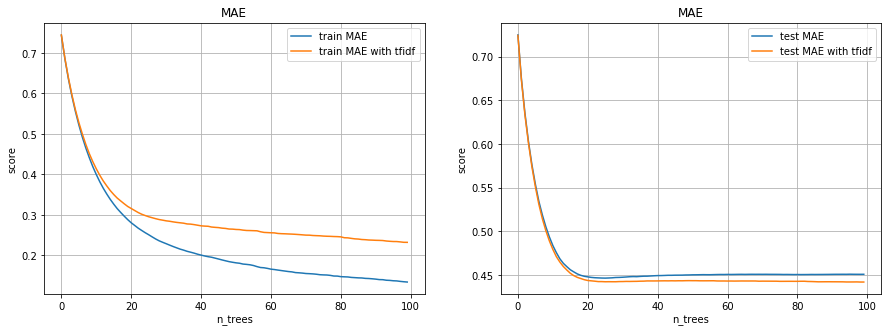

In [145]:
train_rmse_tf, train_mae_tf, test_rmse_tf, test_mae_tf = show_evals(evals_result_tf)
plot_compare(train_evals_mae, 'train MAE', train_mae_tf, 'train MAE with tfidf', test_evals_mae, 'test MAE', 
             test_mae_tf, 'test MAE with tfidf')

<BarContainer object of 68 artists>

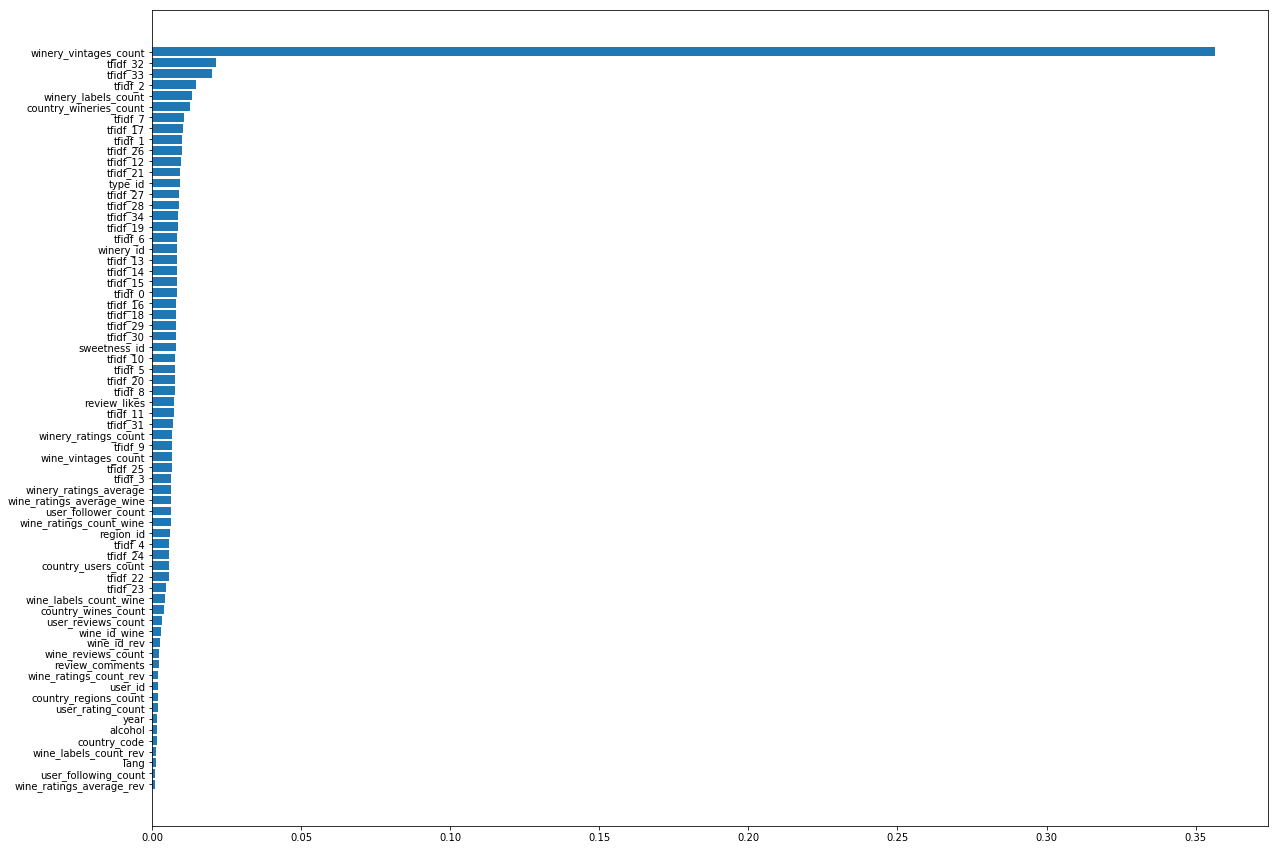

In [149]:
fig = plt.figure(figsize=(20, 15))
plt.barh(*zip(*sorted(importances_tf.items(), key=lambda x:x[1])))

Улучшения особо незаметно, хотя, в отличие от SVD, tf-idf вектора в качестве признаков ведут себя намного приятнее при обучении модели: несмотря на понижающееся качество предсказаний на обучающей выборке, на тестовом сете качество даже чуть улучшается на фоне числовой модели! А значит, нет переобучения.

## Random Tree Embedding

Внесём в полученные взвешенные вектора слов семантическую близость: построим эмбеддинги для данных 1- и 2-грамм с помощью RandomTreeEmbedding. Ансамбль случайных деревьев сопоставляет им некоторые вектора в пространстве большой размерности, отображающие значение в "пространство смыслов" в рамках контекста употребления.

In [150]:
from sklearn.ensemble import RandomTreesEmbedding

rte = RandomTreesEmbedding(n_estimators=20, max_depth=10, random_state=42)

In [151]:
tfidf_features = vectorized_coments[:, idx]
tfidf_feat_test = vectorized_com_test[:, idx]
tfidf_features

<81927x35 sparse matrix of type '<class 'numpy.float64'>'
	with 21486 stored elements in Compressed Sparse Row format>

In [152]:
%time
tfidf_features = rte.fit_transform(tfidf_features)
tfidf_feat_test = rte.transform(tfidf_feat_test)
tfidf_features

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


<81927x1711 sparse matrix of type '<class 'numpy.float64'>'
	with 1638540 stored elements in Compressed Sparse Row format>

In [153]:
X_train, X_test, y_train, y_test = make_X_y(nltk=1)

for i in range(len(idx)):
    name = 'tfidf_' + str(i)
    X_train[name] = pd.Series([x[0] for x in tfidf_features[:,i].todense().tolist()], index=X_train.index)
    X_test[name] = pd.Series([x[0] for x in tfidf_feat_test[:,i].todense().tolist()], index=X_test.index)

imp_columns = X_train.columns

In [154]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print('Обучение: ', X_train.shape, 'Тест: ', X_test.shape)

Обучение:  (81927, 87) Тест:  (15300, 87)


In [155]:
evals_result_embed, importances_embed = xgb_reg(X_train, y_train, X_test, y_test, imp_columns)

[0.724889, 0.674768, 0.635574, 0.60332, 0.576361, 0.553137, 0.533776, 0.517726, 0.503765, 0.49191]


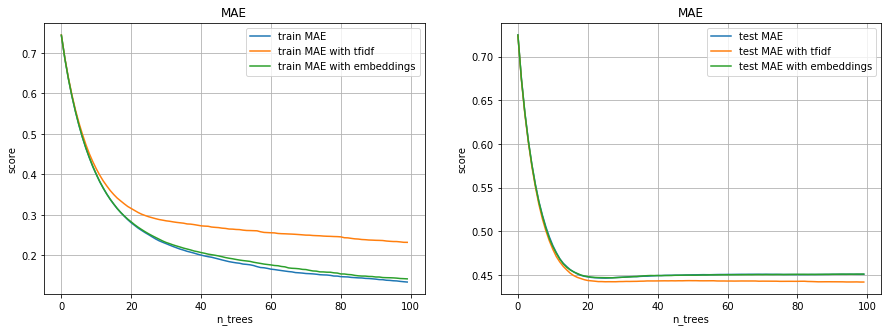

In [156]:
train_rmse_embed, train_mae_embed, test_rmse_embed, test_mae_embed = show_evals(evals_result_embed)
plot_compare(train_evals_mae, 'train MAE', train_mae_tf, 'train MAE with tfidf', test_evals_mae, 'test MAE', 
             test_mae_tf, 'test MAE with tfidf', train_mae_embed, 'train MAE with embeddings', 
             data7=test_mae_embed, label7='test MAE with embeddings')

## XGBoost с учетом SVD и tfidf

In [160]:
X_train, X_test, y_train, y_test = make_X_y(nltk=1)

X_train['svd_sum'] = pd.Series(res_train, index=X_train.index)
X_test['svd_sum'] = pd.Series(res_test, index=X_test.index)

for i in range(len(idx)):
    name = 'tfidf_' + str(i)
    X_train[name] = pd.Series([x[0] for x in tfidf_features[:,i].todense().tolist()], index=X_train.index)
    X_test[name] = pd.Series([x[0] for x in tfidf_feat_test[:,i].todense().tolist()], index=X_test.index)

imp_columns = X_train.columns

In [161]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print('Обучение: ', X_train.shape, '\t\tТест: ', X_test.shape)

Обучение:  (81927, 88) 		Тест:  (15300, 88)


In [162]:
evals_result_tf_svd, importances_tf_svd = xgb_reg(X_train, y_train, X_test, y_test, imp_columns)

[0.727705, 0.680059, 0.642227, 0.611593, 0.585767, 0.563429, 0.544594, 0.528124, 0.514405, 0.502527]


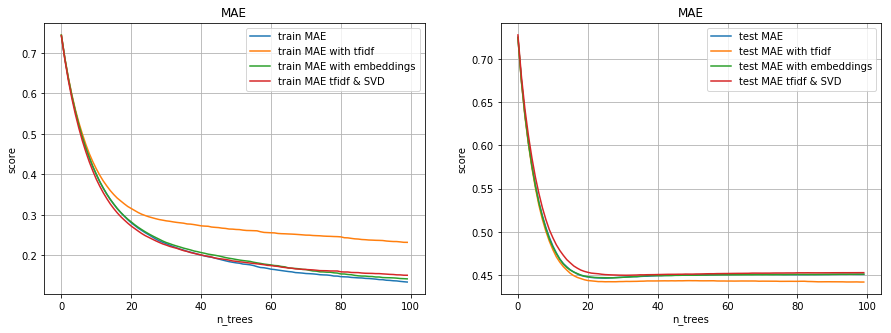

In [163]:
train_rmse_tf_svd, train_mae_tf_svd, test_rmse_tf_svd, test_mae_tf_svd = show_evals(evals_result_tf_svd)
plot_compare(train_evals_mae, 'train MAE', train_mae_tf, 'train MAE with tfidf', test_evals_mae, 'test MAE', 
             test_mae_tf, 'test MAE with tfidf', train_mae_embed, 'train MAE with embeddings', train_mae_tf_svd,
             'train MAE tfidf & SVD', test_mae_embed, 'test MAE with embeddings', test_mae_tf_svd, 
             'test MAE tfidf & SVD')

<BarContainer object of 69 artists>

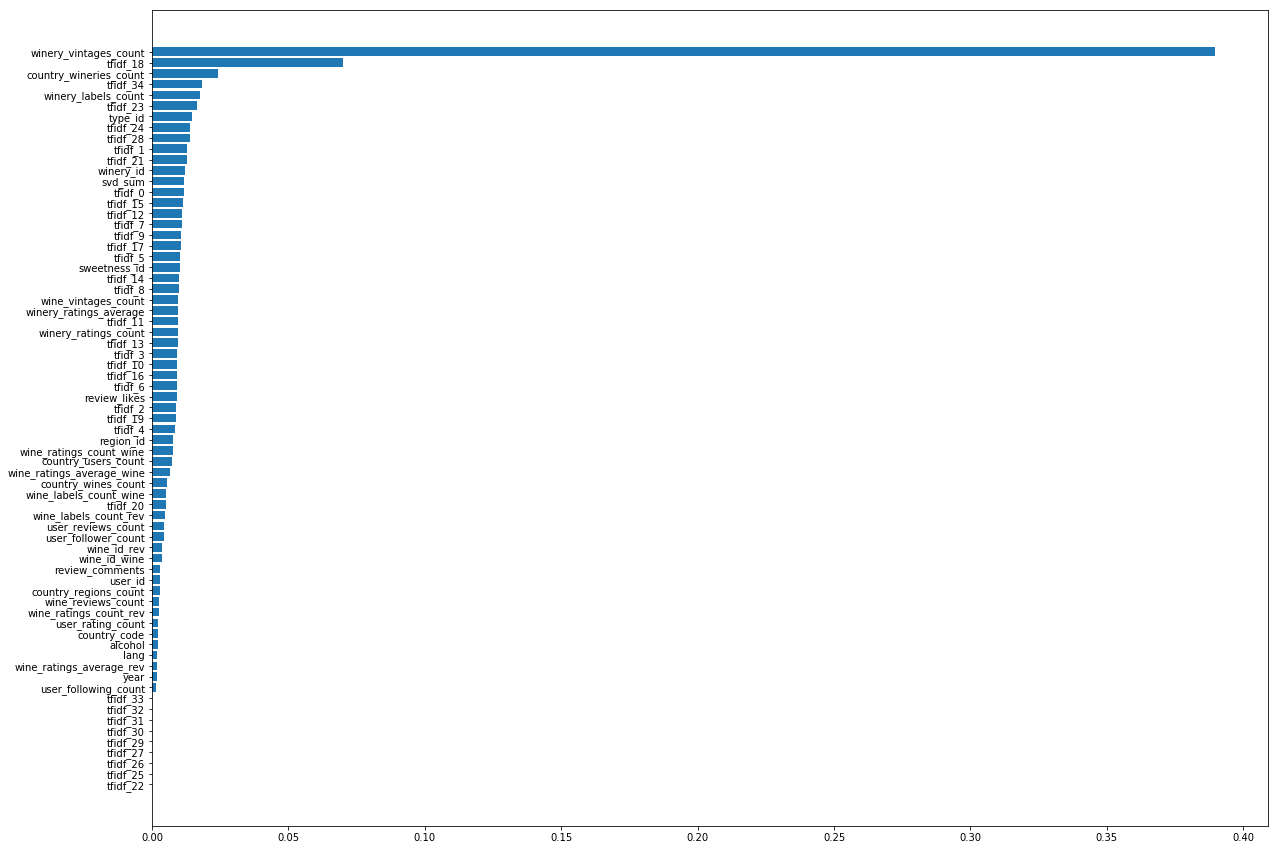

In [164]:
fig = plt.figure(figsize=(20, 15))
plt.barh(*zip(*sorted(importances_tf_svd.items(), key=lambda x:x[1])))

## Summary

Как видно, пока всевозможные попытки изменить количество и качество данных в обучении моделей не приносит заметный прирост качества предсказаний. Во многом это объясняется зашумлённостью данных и множеством выбросов в них (что было показано при первичном визуальном анализе признаков в начале статьи). 

В датасете оказалось мало пользователей, оставивших достаточное количество оценок, чтобы стандартные методы коллаборативной фильтрации могли обучиться на имеющихся данных. Вероятно, в рамках этой задачи от матричной факторизации стоит отказаться и нацелиться только на использование информативных признаков о вине. Тот факт, что использованное SVD++ разложение так быстро переобучалось при добавлении к признакам смещения по пользователям и смещения по винам, объясняется тем, что большую часть датасета занимают пользователи с очень краткой историей взаимодействий, на которых SVD++ просто запоминает имеющуюся единственную оценку. Такое смещение, переданное в качестве признака, мало что говорит о предпочтениях пользователя, но влечёт подгонку под обучающий датасет. Аналогично со смещением по винам. 

Иными словами, для коллаборативной фильтрации необходимо больше информации о взаимодействии пользователей с винами, потому как большая часть данных оказывается вообще непригодной для практического применения SVD, а при настройке отбора данных, остаётся лишь малая часть пользователей, для которых вычисляемый прогноз оказывается приемлем.

Обработка текстовых признаков не выглядит такой безнадёжной идеей: качество предсказаний не ухудшается. Имеет смысл в дальнейшем подробнее рассмотреть, как добавление векторных представлений слов будет вести себя при другом разбиение на обучающую и тестовую выборки (вне зависимости от наших предположений об SVD-разложнии), других параметрах xgboost. Здесь же стоит упомянуть, что, судя по графикам зависимости ошибок от количества деревьев в xgboost-е, много деревьев нам не нужно. В конце концов, 99 000 данных - не так много для обработки. 

Напоследок учтём такое наблюдение: какую бы новую информацию мы ни добавляли к фичам, наиболее важным признаком xgboost считает "winery_vintages_count" - количество сборов урожая винодельни-производителя вина. Такое сильное влияние этого фактора неочевидно, хотя вполне допустимо с точки зрения здравого смысла. 

Построим график зависимости таргета от этого признака.

Максимальное значение winery_vintages_count:  223.0
Минимальное значение winery_vintages_count:  0.0


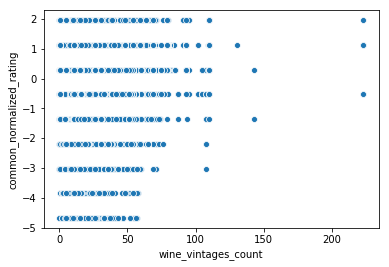

In [180]:
print("Максимальное значение winery_vintages_count: ", df_joined['wine_vintages_count'].max())
print("Минимальное значение winery_vintages_count: ", df_joined['wine_vintages_count'].min())
sns.scatterplot(x="wine_vintages_count", y="common_normalized_rating", data=df_joined)

Подобная зависимость не очень близка к линейной, однако есть примечательные закономерности, которыми объясняется столь ярко выраженное влияние признака на таргет. Число сборов для вин с плохими оценками строго сгруппировано и не превышает 70. С увеличением нормализованной оценки заметно увеличивается разброс числа сборов винограда, а самые критические значения > 200 сборов соответствуют только винам, заслужившим среднюю и выше оценки. Естесственно, что модель машинного обучения увидит в таких данных закономерность.

Однако, стоит принять во внимание, что экстремальные значения winery_vintages_count можно легко отбросить как шумовые на этапе предобработки данных, тогда зависимость несколько утратит линейность и очевидность. 

Кроме того, есть и другие подходы к выделению значимых для моделей признаков, и xgbdoost_importances не является лучшей из них. Стоит подойти со стороны shap values и посмотреть на получившиеся признаки.

Есть ещё один момент, требующий обсуждения: влияние текстовых признаков на предсказания рейтингов. В обоих графиках важности признаков было отражено, что мера tfidf слова в комментарии, оставленном при оценке играет немаловажную роль. При этом, при обучении xgb только на числовых и текстовых признаках, важными оказались слова: 

In [192]:
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k

print(get_key(vect.vocabulary_, idx[32]))
print(get_key(vect.vocabulary_, idx[33]))
print(get_key(vect.vocabulary_, idx[2]))

refresh
tabl wine
okay


А при добавлении результатов работы SVD приобрели важность:

In [193]:
print(get_key(vect.vocabulary_, idx[18]))
print(get_key(vect.vocabulary_, idx[34]))
print(get_key(vect.vocabulary_, idx[23]))

good valu
sweet not
dinner


Точно обосновать эту разницу нельзя, так  как tfidf мера всегда очень завязана на конкретном корпусе текста (комментарии), на частотности слова в корпусе и его семантической важности. 

### Дальнейший анализ:

Во-первых, стоит отказаться от SVD (по крайней мере на данных в том виде, в котором они есть сейчас). Построить случайное разбиение и получить более честные оценки для xgboost с числовыми и текстовыми признаками с перекрестной проверкой.

Во-вторых, имеет смысл усовершенствовать эвристику, с которой мы подошли к векторизации комментариев. Вероятно, можно достичь лучших результатов с другими параметрами отбора слов по втречаемости и весу.

В-третьих, попробовать отобрать лишь значимые признаки, отбросить шумовые значения. Как было показано выше, сейчас наибольшее влияние на предсказываемую оценку играет признак winery_vintages_count. Возможно, отбор методами TruncatedSVD или shap importances переиграют эту ситуацию.

Кроме того, у нас очень много данных по вину. Можно попробовать использовать на признаках и описании косинусную меру для измерения похожести вин. Это в идеале позволит круто рекомендовать продукты одной винодельни/одного купажа, но, скорее всего, на обобщении кислотности, алкоголя и прочих хим.параметров, влияющих на вкус, обломается.

Как вишенку на торте можно завести нейросеть с аттеншенами, хотя в рамках такого небольшого датасета это представляется ударом пушкой по воробьям.

Иными словами, проделанная работа - лишь начальный этап знакомства с данными, их обработки и пробы наиболее популярных подходов к построению рекомендательных систем. Особую прелесть имеет естественность датасета, где данные разительно отличаются от обычных обучающих материалов без выбросов, шума и с очевидными зависимостями. Спасибо, что прочли до конца, надеюсь, Вам было так же интересно, как и мне.